<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/image_pred_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [1]:
%%capture
!pip -q install rasterio

In [54]:
import os
import re
import rasterio
import rasterio.features
from rasterio.features import rasterize
from rasterio.enums import MergeAlg
import json
from shapely.geometry import LineString, Polygon

# Data manipulation and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import curve_fit


# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Download  data to local compute node

## Mount your Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compress files, copy over to compute node, and uncompress

In [ ]:
# Navigate to the shared directory
#%cd /content/drive/MyDrive/Zindi-Amazon/
#!zip -r /content/predictions.zip WhateverDirectory
#!unzip /content/predictions.zip -d /content

# Functions


In [5]:
def process_clusters(binary_mask):
    """
    Identifies and processes clusters (connected components) in the binary mask.
    """

    # Label connected components in the mask
    labeled_mask = label(binary_mask)
    clusters = regionprops(labeled_mask)
    image_height, image_width = binary_mask.shape  # Get image dimensions

    lines = []

    for cluster in clusters:
        # Check if the cluster has enough points for PCA
        if cluster.area < 2:  # At least 2 points needed for PCA
            # Handle clusters with insufficient points (e.g., skip, merge, etc.)
            print(f"Skipping cluster with {cluster.area} points - insufficient for PCA.")
            continue  # Skip this cluster

        # Extract the coordinates of the pixels in the cluster
        coords = cluster.coords

        # Perform PCA to find the main axis
        pca = PCA(n_components=2)
        pca.fit(coords)
        direction = pca.components_[0]
        variance = pca.explained_variance_

        # Compute the length of the cluster along the principal axis
        projected_coords = coords @ direction
        min_proj, max_proj = projected_coords.min(), projected_coords.max()
        length = max_proj - min_proj

        # Calculate width by projecting orthogonal to main axis
        # Using the max / min values we get a width that covers all
        # points, but could be impacted by outliers.
        # Using the standard deviation, we may be less susceptible to
        # outliers. Using 2 time the std, we cover 68% of all points. Using
        # 4 times the std would cover 95%. Something to test.
        orthogonal_direction = pca.components_[1]
        orthogonal_proj = coords @ orthogonal_direction
        width = orthogonal_proj.max() - orthogonal_proj.min()
        std = np.std(orthogonal_proj)

        # Compute length-to-width ratio
        length_width_ratio = length / width if width != 0 else np.inf

        # Check if line touches the border:
        touches_border = any(
            (x == 0 or x == image_width - 1 or y == 0 or y == image_height - 1)
            for x, y in coords
        )


        # Get endpoints of the line along the main axis
        endpoint1 = pca.mean_ + direction * (min_proj - pca.mean_ @ direction)
        endpoint2 = pca.mean_ + direction * (max_proj - pca.mean_ @ direction)
        lines.append({
            "length": length,
            "width": width,
            "std": std,
            "ratio": length_width_ratio,
            "boundary": touches_border,
            "endpoints": (endpoint1, endpoint2)
        })

    return lines

In [11]:
def plot_clusters_and_lines(binary_mask, lines):
    plt.figure(figsize=(5,5))  # Set figure size
    plt.imshow(binary_mask, cmap="gray")
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]
        plt.plot([y1, y2], [x1, x2], 'r-')
    plt.show()


In [6]:
def load_binary_mask_from_geotiff(geotiff_path):
    """
    Loads the binary mask from a GeoTIFF file and returns it as a NumPy array.
    """
    with rasterio.open(geotiff_path) as src:
        # Read the first band (assuming the binary mask is single-band and in the first band)
        binary_mask = src.read(1)

    # Ensure mask is binary (values should be 0 or 1)
    binary_mask = (binary_mask > 0).astype(np.uint8)

    return binary_mask


In [ ]:
def lines_to_geojson(lines, geotiff_path, buffer_distance=200):
    """
    Converts lines with pixel coordinates to GeoJSON LINESTRING features
    using the GeoTIFF metadata, including the CRS.

    Args:
        lines: A list of line dictionaries, each with "endpoints" key.
        geotiff_path: Path to the GeoTIFF file.
        buffer_distance: Buffer distance in meters.

    Returns:
        A GeoJSON FeatureCollection containing the Polygon features with buffer.
    """

    with rasterio.open(geotiff_path) as src:
        transform = src.transform
        crs = src.crs

    features = []
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]

        # Convert pixel coordinates to geographic coordinates
        lon1, lat1 = rasterio.transform.xy(transform, x1, y1)
        lon2, lat2 = rasterio.transform.xy(transform, x2, y2)

        # Create Shapely LineString
        line_geom = LineString([(lon1, lat1), (lon2, lat2)])

        # Buffer the LineString (assuming UTM coordinates)
        polygon_geom_signal = line_geom.buffer(20)
        polygon_geom_buffer = line_geom.buffer(buffer_distance)

        # Create GeoJSON Polygon feature
        feature = {
            "type": "Feature",
            "geometry": polygon_geom_buffer.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"],
                "signal": 2
            }
        }
        features.append(feature)
        feature = {
            "type": "Feature",
            "geometry": polygon_geom_signal.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"],
                "signal": 1
            }
        }
        features.append(feature)

    # Create GeoJSON FeatureCollection with CRS
    geojson = {
        "type": "FeatureCollection",
        "features": features,
        "crs": {
            "type": "name",
            "properties": {
                "name": crs.to_string()  # Get CRS as a string
            }
        }
    }

    return geojson


In [ ]:
def create_mask_from_geojson(geojson_data, geotiff_path, output_path):
    """
    Creates a new GeoTIFF mask from GeoJSON polygons,
    using the metadata of an existing GeoTIFF.

    Args:
        geojson_data: The GeoJSON data containing the polygons.
        geotiff_path: Path to the original GeoTIFF file.
        output_path: Path to save the new GeoTIFF mask.
    """

    with rasterio.open(geotiff_path) as src:
        # Get metadata from original GeoTIFF
        meta = src.meta.copy()

        # Update data type to uint8 for binary mask
        #meta.update(dtype=rasterio.uint8, count=1, nodata=None)
        meta.update(dtype=rasterio.uint8, count=1, nodata=0)

        # Create an empty mask array
        mask = np.zeros((meta['height'], meta['width']), dtype=rasterio.uint8)

        # Rasterize GeoJSON polygons onto the mask with value 1
        #for feature in geojson_data['features']:
        #    # Burn the polygon with a value of 1
        #    # Use rasterio.features.rasterize instead of features.rasterize
        #    rasterio.features.rasterize(
        #        [(feature['geometry'], 1)],
        #        out=mask,
        #        transform=meta['transform'],
        #        all_touched=True,
        #        #default_value=1,  # Set polygon value to 1
        #        default_value=np.uint8(feature['properties']['signal']),  # Set polygon value to 1
        #        dtype=rasterio.uint8,
        #    )

        # Prepare geometries with associated 'signal' values for rasterization
        shapes = [(feature['geometry'], feature['properties']['signal']) for feature in geojson_data['features']]

        # Rasterize the shapes with their respective 'signal' values
        rasterio.features.rasterize(
            shapes,
            out=mask,
            transform=meta['transform'],
            all_touched=True,
            dtype=rasterio.uint8,
            merge_alg=MergeAlg.replace  # Ensure each shape overwrites previous values
        )


        # Write the new mask to a GeoTIFF file
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(mask, indexes=1)


In [ ]:
def create_dataframe_from_mask(mask_path, aoi_file):
    """
    Creates a Pandas DataFrame from a GeoTIFF mask file,
    extracting pixels with value 1.

    Args:
        mask_path: Path to the GeoTIFF mask file.
        aoi_file: Name of the AOI file (used in the DataFrame index).

    Returns:
        A Pandas DataFrame with columns 'pixel_id' and 'value'.
    """

    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)  # Read the mask data as a NumPy array

    # Get indices of pixels with value 1 or 2
    row_indices, col_indices = np.where((mask_data == 1) | (mask_data == 2))

    # --- Overwrite label with 0 when mask_data is 2 ---
    labels = mask_data[row_indices, col_indices]  # Get original labels
    labels[labels == 2] = 0  # Overwrite 2 with 0

    # Create a list of pixel IDs in the specified format
    #
    # NOTICE THAT THE ZINDI TEAM FLIPPED THE COLUMN AND ROW!!!! THIS IS SO
    # WEIRD. MAKES NO SENSE TO BREAK WITH CONVENTIONS
    #
    #pixel_ids = [f'Tile{aoi_file}_{row}_{col}' for row, col in zip(row_indices, col_indices)]
    pixel_ids = [f'Tile{aoi_file}_{row}_{col}' for row, col in zip(col_indices, row_indices)]

    # Create the DataFrame
    df = pd.DataFrame({'tile_row_column': pixel_ids, 'label': labels})
    df.set_index('tile_row_column', inplace=True)

    return df

In [ ]:
def export_dataframe_to_csv(df, csv_path):
    """
    Exports a Pandas DataFrame to a CSV file, appending if the file exists.

    Args:
        df: The Pandas DataFrame to export.
        csv_path: Path to the CSV file.
    """

    # Check if the file exists
    if os.path.exists(csv_path):
        # Append to the existing file without header
        df.to_csv(csv_path, mode='a', header=False, index=True)
    else:
        # Create a new file with header
        df.to_csv(csv_path, mode='w', header=True, index=True)


In [ ]:
def extract_model_bands(text):
    """
    Extracts the part of the string after "lr0005".

    Args:
      text: The input string.

    Returns:
      The part of the string after "lr0005", or None if "lr0005" is not found.
    """
    match = re.search(r"lr0005_(.*)", text)
    if match:
        return match.group(1)
    else:
        return None


In [ ]:
def modify_string_for_submission_file(input_string):
    """
    Removes "20" from the input string if it's in the format "aoi_20YY_MM".

    Args:
      input_string: The input string.

    Returns:
      The modified string with "20" removed, or the original string if
      it doesn't match the expected format.
    """
    return re.sub(r"aoi_20(\d\d)_(\d\d)", r"aoi_\1_\2", input_string)


# Main loop

This is where we load the GeoTIFF file prediction, find the clusters,
clean the image and then produce a final prediction. Notice that the final prediction must have a 200 meter buffer.

Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_00_00.tif
 Length: 83.86141787180489, Width: 6.584573445986649, Std: 1.4554522648881512, Ratio: 12.73604411276164, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_00_01.tif
 Length: 66.56931512094512, Width: 5.116860598653659, Std: 1.3647519733282905, Ratio: 13.009796502656481, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_00_02.tif
 Length: 41.300107146488536, Width: 5.44919392329335, Std: 1.4511930520601706, Ratio: 7.579122293656202, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_00_03.tif
 Length: 21.6330474317598, Width: 3.9250256223367046, Std: 0.9909541010071954, Ratio: 5.51156846178265, Boundary: False
 Length: 41.62735896710343, Width: 12.317670701524385, Std: 2.700658873903983, Ratio: 3.379483018810675, Boundary: False


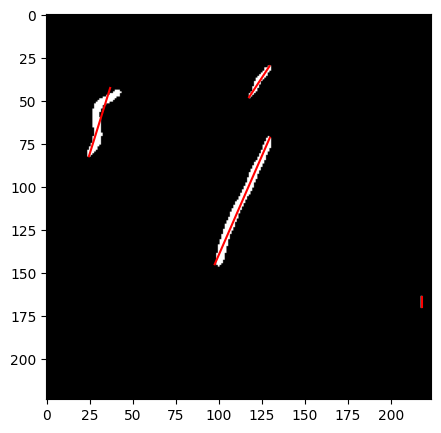

 Length: 80.34176822024065, Width: 7.109545289212917, Std: 1.5439518555722642, Ratio: 11.300549465820355, Boundary: False
 Length: 6.0, Width: 0.0, Std: 0.0, Ratio: inf, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_00_04.tif
 Length: 3.0, Width: 0.0, Std: 0.0, Ratio: inf, Boundary: False
 Length: 81.23147267178395, Width: 6.410502799654303, Std: 1.4714494590732308, Ratio: 12.671622680855002, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_00_05.tif
 Length: 31.016005472560238, Width: 4.791550739505368, Std: 1.2113394441480103, Ratio: 6.473062095918037, Boundary: False
 Length: 62.28322782936087, Width: 5.413291069563371, Std: 1.3744562917458234, Ratio: 11.50561221057425, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_00_06.tif
 Length: 70.0674943859604, Width: 9.649035134723597, Std: 1.9081549415473635, Ratio: 7.261606306501187, Boundary

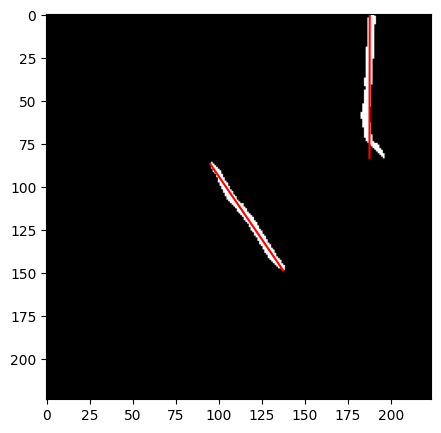

 Length: 74.8857199133774, Width: 6.165366845854287, Std: 1.391479598842511, Ratio: 12.14619045154337, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_02_00.tif
 Length: 75.36208463383761, Width: 5.386972173070816, Std: 1.4191370037414766, Ratio: 13.989692579176223, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_02_01.tif
 Length: 77.64171079546327, Width: 5.489560603018774, Std: 1.3310280675001795, Ratio: 14.143520112113743, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_02_02.tif
 Length: 52.79324067771648, Width: 5.202304327096094, Std: 1.2972217870663736, Ratio: 10.148049279382597, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_02_03.tif
 Length: 261.7176481752865, Width: 6.901508048909392, Std: 1.4282147061195234, Ratio: 37.92180583150147, Boundary: True
Processing /content/drive/MyDri

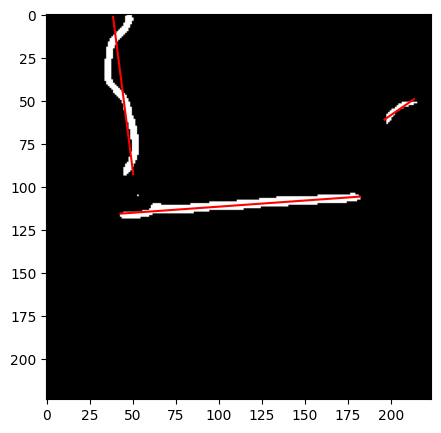

 Length: 20.807418209659545, Width: 5.080925204957339, Std: 1.3281456533007834, Ratio: 4.095202619664277, Boundary: False
 Length: 139.4300986163866, Width: 7.412651634684721, Std: 1.5594991509509888, Ratio: 18.80974656410073, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_04_03.tif
 Length: 59.04972385541522, Width: 4.820025365396461, Std: 1.1438826413554268, Ratio: 12.250915582175201, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_04_04.tif
 Length: 19.6959554137959, Width: 3.939411535400211, Std: 0.9428812631290557, Ratio: 4.99972019597464, Boundary: False
 Length: 56.90818241764934, Width: 5.111397659416809, Std: 1.2942093465338351, Ratio: 11.133585412359082, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_04_05.tif
 Length: 66.63135553942983, Width: 6.277157465233188, Std: 1.374804344621177, Ratio: 10.61489311180671, Boundary: False
P

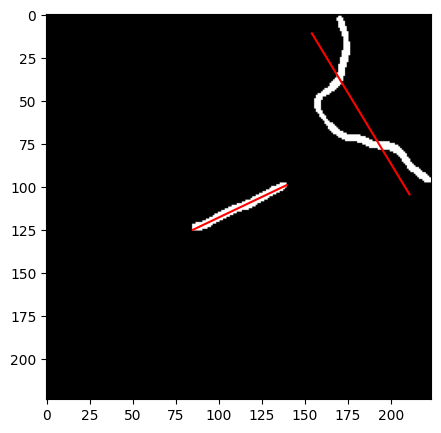

 Length: 60.36308970980595, Width: 5.711537116313224, Std: 1.426708638521055, Ratio: 10.568624256576678, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_10_03.tif
 Length: 36.21531137403477, Width: 6.738522057425456, Std: 1.6366019706497454, Ratio: 5.374370086705826, Boundary: True
 Length: 9.431352687642594, Width: 2.389777388726202, Std: 0.6352584433516278, Ratio: 3.9465402644342906, Boundary: False
 Length: 110.35945498758753, Width: 8.944721966836234, Std: 1.7900124305662293, Ratio: 12.337941346501337, Boundary: False
 Length: 100.55321862284251, Width: 7.202367885191389, Std: 1.5615064633625404, Ratio: 13.961133369705745, Boundary: True
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_10_04.tif
 Length: 110.89996500136652, Width: 5.731852419310428, Std: 1.3917443347755476, Ratio: 19.348014723433575, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_10_05.

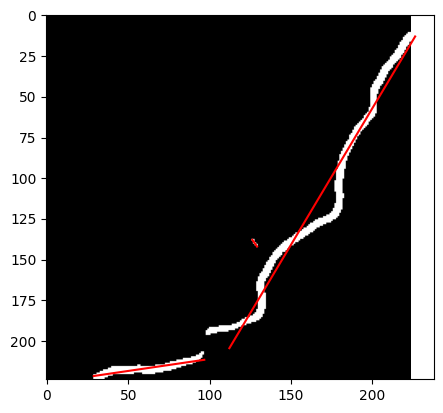

 Length: 4.997361484089851, Width: 1.1473943846065282, Std: 0.37639533374504075, Ratio: 4.355399983767201, Boundary: False
 Length: 68.61168396722671, Width: 8.65879581555322, Std: 1.7549416549021186, Ratio: 7.92392908076018, Boundary: True
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_11_02.tif
 Length: 61.6160311612719, Width: 5.292638079396738, Std: 1.3829692560777058, Ratio: 11.641837253359855, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_11_03.tif
 Length: 142.55753786233274, Width: 5.276846285044975, Std: 1.329667613745787, Ratio: 27.01566999712551, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_11_04.tif
 Length: 75.58016842622662, Width: 4.5400065128460625, Std: 1.2692855948874153, Ratio: 16.647590309038243, Boundary: False
 Length: 121.45697660151035, Width: 26.529574659425464, Std: 5.750974693363917, Ratio: 4.578172781159118, Boundary: True


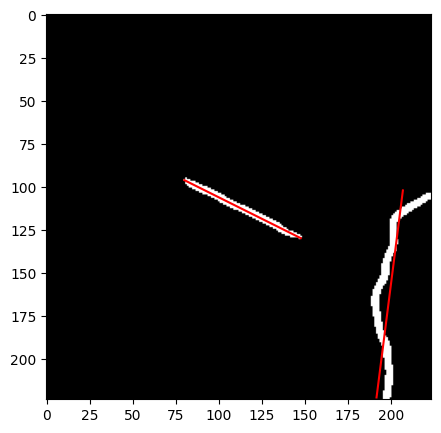

Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_11_05.tif
 Length: 77.77963338497288, Width: 4.704673376193137, Std: 1.1809154647241977, Ratio: 16.532419397817907, Boundary: False
 Length: 1.414213562373078, Width: 0.7071067811865532, Std: 0.33333333333333603, Ratio: 1.9999999999999598, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_11_06.tif
 Length: 108.53308822729487, Width: 7.972869690284185, Std: 1.723848393800067, Ratio: 13.612800966702657, Boundary: False
 Length: 108.71784905247023, Width: 9.136528879713481, Std: 1.801464295797615, Ratio: 11.899250851585947, Boundary: True
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_11_07.tif
 Length: 84.01190352439116, Width: 5.2579058027721, Std: 1.332402649516514, Ratio: 15.978206281310321, Boundary: False
Processing /content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_12_00.tif
Processing /content/drive/My

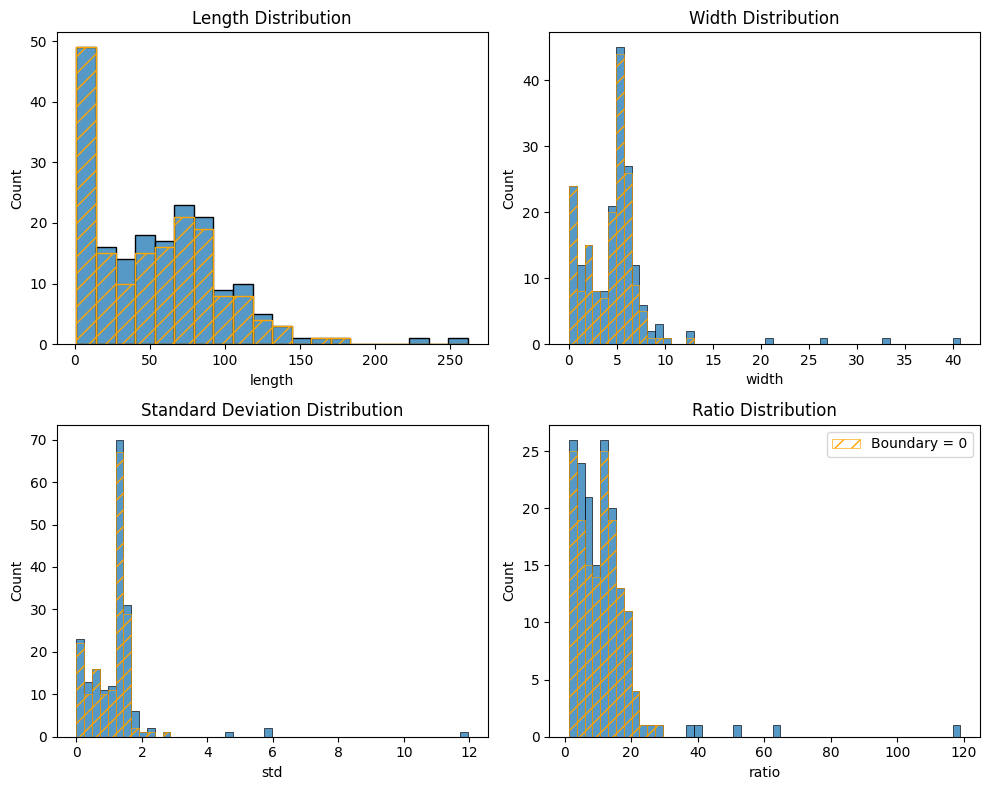

            length     width       std     ratio  boundary
length    1.000000  0.575877  0.504078  0.536447  0.252818
width     0.575877  1.000000  0.972984 -0.077461  0.426398
std       0.504078  0.972984  1.000000 -0.092249  0.377874
ratio     0.536447 -0.077461 -0.092249  1.000000  0.285467
boundary  0.252818  0.426398  0.377874  0.285467  1.000000


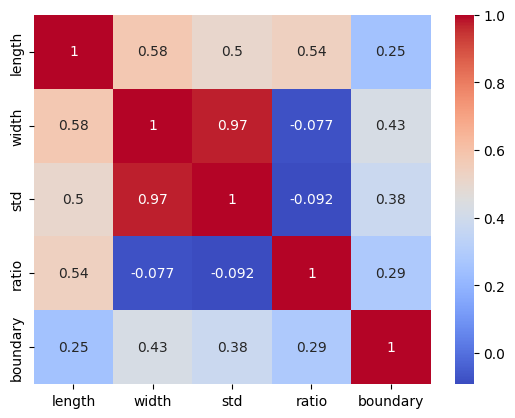

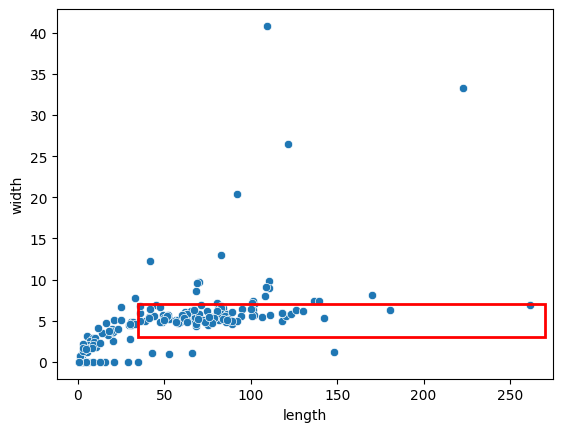

Mean: 6.73
Standard Deviation: 4.97


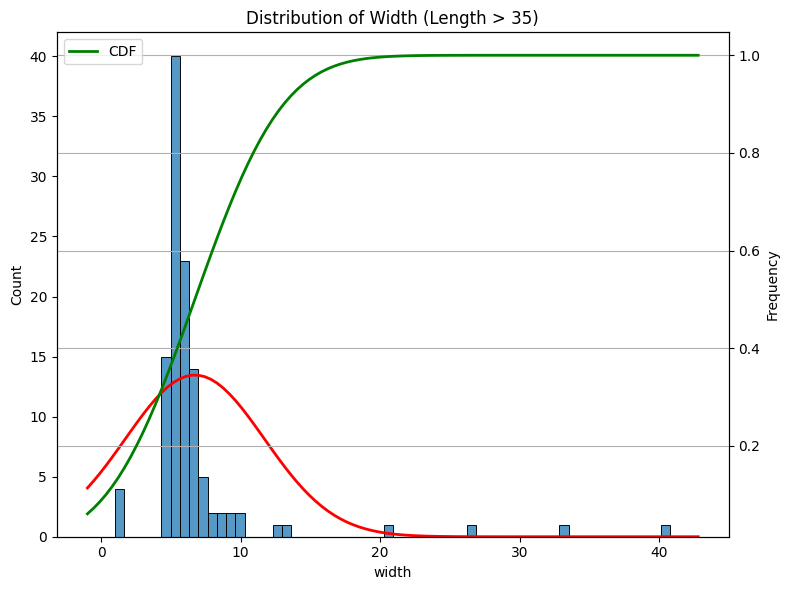

Mean: 1.59
Standard Deviation: 1.21


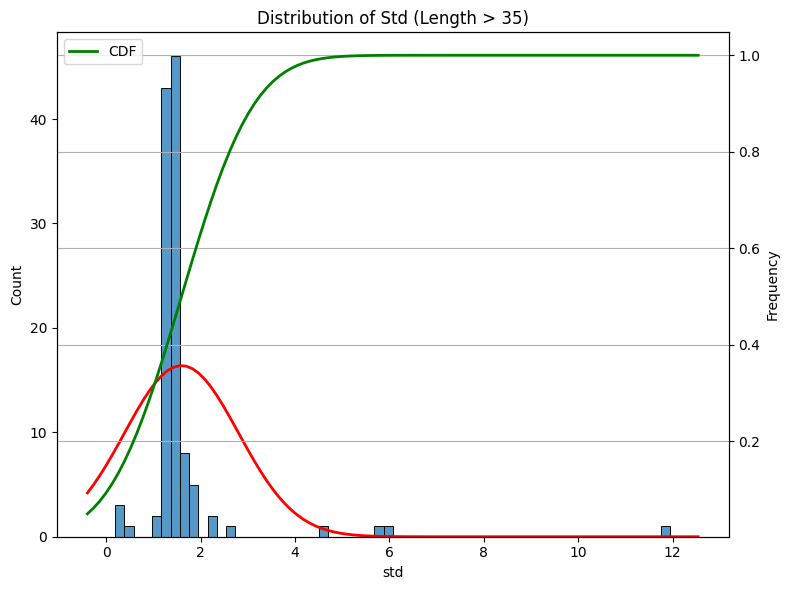

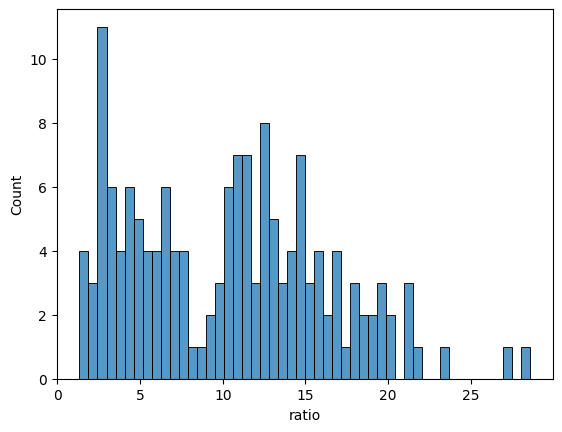

In [60]:
# List image file paths
file_dir = '/content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions'
image_paths = [os.path.join(file_dir, img) for img in sorted(os.listdir(file_dir)) if img.endswith('.tif')]


all_line_stats = []  # Initialize and empty list

#aoi_files = ['aoi_2020_01', 'aoi_2020_02', 'aoi_2020_03', 'aoi_2021_01', 'aoi_2021_02', 'aoi_2021_03', 'aoi_2021_04', 'aoi_2022_01', 'aoi_2022_02', 'aoi_2023_01', 'aoi_2024_01']
#aoi_directory = '/content/drive/MyDrive/Zindi-Amazon/Studies/model_20241030_20m_lr0005_B4_B3_B2_B8_VV'

# Loop over the prediction files and get stats.
for pred_file in image_paths:
    print(f'Processing {pred_file}')
    #geotiff_path = f'{aoi_directory}/{aoi_file}_prediction_mosaic.tif'

    binary_mask = load_binary_mask_from_geotiff(pred_file)
    lines = process_clusters(binary_mask)

    #plot_clusters_and_lines(binary_mask, lines)

    # Output the line information
    for line in lines:
        print(f" Length: {line['length']}, Width: {line['width']}, Std: {line['std']}, Ratio: {line['ratio']}, Boundary: {bool(line['boundary'])}")
        #print(f" Endpoints: {line['endpoints']}")
        # Extract the stats...
        all_line_stats.append({
            "length": line['length'],
            "width": line['width'],
            "std": line['std'],
            "ratio": line['ratio'],
            "boundary": line['boundary']
        })
        if line['length'] > 35 and line['width'] > 10:
            plot_clusters_and_lines(binary_mask, lines)



    # Convert lines to GeoJSON object.
    #geojson_data = lines_to_geojson(lines, geotiff_path)

    # Get model bands stored in name of the directory.
    #bands = extract_model_bands(aoi_directory)

    # Create final mask with padding.
    #create_mask_from_geojson(geojson_data, geotiff_path, f'{aoi_file}_{bands}_prediction_final.tif')

    #submission_tag = modify_string_for_submission_file(aoi_file)
    #df = create_dataframe_from_mask(f'{aoi_file}_{bands}_prediction_final.tif', submission_tag)
    #print(f'Number of pixels with background or signal:{len(df)}')

    #csv_path = f'output_file_{bands}.csv'  # Path to your CSV file
    #export_dataframe_to_csv(df, csv_path)

stats_df = pd.DataFrame(all_line_stats)



# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust figsize as needed

# Plot histograms on individual subplots
_, bins = np.histogram(stats_df["length"], bins=20)  # Use 'auto' or specify a number
sns.histplot(data=stats_df, x="length", label="All Lengths", ax=axes[0, 0], bins=bins)
sns.histplot(data=stats_df[stats_df["boundary"] == 0], x="length", label="Boundary = 0", color="none", ax=axes[0, 0], bins=bins, edgecolor="orange", hatch="//")

_, bins = np.histogram(stats_df["width"], bins=50)  # Use 'auto' or specify a number
sns.histplot(data=stats_df, x="width", ax=axes[0, 1], bins=bins)
sns.histplot(data=stats_df[stats_df["boundary"] == 0], x="width", label="Boundary = 0", color="none", ax=axes[0, 1], bins=bins, edgecolor="orange", hatch="//")

_, bins = np.histogram(stats_df["std"], bins=50)  # Use 'auto' or specify a number
sns.histplot(data=stats_df, x="std", ax=axes[1, 0], bins=bins)
sns.histplot(data=stats_df[stats_df["boundary"] == 0], x="std", label="Boundary = 0", color="none", ax=axes[1, 0], bins=bins, edgecolor="orange", hatch="//")

_, bins = np.histogram(stats_df["ratio"][np.isfinite(stats_df["ratio"])], bins=50)  # Use 'auto' or specify a number
sns.histplot(data=stats_df, x="ratio", ax=axes[1, 1], bins=bins)
sns.histplot(data=stats_df[stats_df["boundary"] == 0], x="ratio", label="Boundary = 0", color="none", ax=axes[1, 1], bins=bins, edgecolor="orange", hatch="//")

# Set titles for each subplot
axes[0, 0].set_title("Length Distribution")
axes[0, 1].set_title("Width Distribution")
axes[1, 0].set_title("Standard Deviation Distribution")
axes[1, 1].set_title("Ratio Distribution")
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.legend()
plt.show()



correlation_matrix = stats_df.corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

#sns.scatterplot(data=stats_df[stats_df["boundary"] == 0], x="length", y="width")  # Example
sns.scatterplot(data=stats_df, x="length", y="width")  # Example
rect = patches.Rectangle((35, 3), 270 - 35, 7 - 3, linewidth=2, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.show()



# Filter data for length greater than 35 (350 meters)
filtered_stats_df = stats_df[stats_df["length"] > 35]
# Extract width data for the filtered DataFrame
width_data = filtered_stats_df["width"]
# Fit a Gaussian distribution
mu, std = norm.fit(width_data)
# Print mean and standard deviation
print(f"Mean: {mu:.2f}")
print(f"Standard Deviation: {std:.2f}")
# Create histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(width_data, bins=60, kde=False, label="Histogram")  # kde=False to hide KDE
# Plot Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(width_data) * (xmax - xmin) / 30, 'r', linewidth=2, label="Gaussian Fit")  # Adjust scaling for visual fit
# Plot cumulative distribution function (CDF)
cdf = norm.cdf(x, mu, std)
plt.twinx()  # Create a secondary y-axis
plt.plot(x, cdf, 'g', linewidth=2, label="CDF")
# Set plot labels and title
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Distribution of Width (Length > 35)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter data for length greater than 35 (350 meters)
filtered_stats_df = stats_df[stats_df["length"] > 35]
# Extract width data for the filtered DataFrame
width_data = filtered_stats_df["std"]
# Fit a Gaussian distribution
mu, std = norm.fit(width_data)
# Print mean and standard deviation
print(f"Mean: {mu:.2f}")
print(f"Standard Deviation: {std:.2f}")
# Create histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(width_data, bins=60, kde=False, label="Histogram")  # kde=False to hide KDE
# Plot Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p * len(width_data) * (xmax - xmin) / 30, 'r', linewidth=2, label="Gaussian Fit")  # Adjust scaling for visual fit
# Plot cumulative distribution function (CDF)
cdf = norm.cdf(x, mu, std)
plt.twinx()  # Create a secondary y-axis
plt.plot(x, cdf, 'g', linewidth=2, label="CDF")
# Set plot labels and title
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Distribution of Std (Length > 35)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


sns.histplot(data=stats_df[(stats_df["length"] > 35) & stats_df["boundary"] == 0], x="ratio", label="Lenght > 35; Boundary = 0", bins=50)
plt.show()

